# WORD ADJACENCY NETWORKs -- A Python Script by Gabriel Egan
ADAPTED FOR USE WITH JUPYTER NOTEBOOK by Alexander Krett

(This version does not stop the 5-word window at speech-breaks.)

In the same folder as this program there should exist the following file:

1) "function_words.txt"

and the following folder containing ASCII text files (with the extension ".txt"):

1) "books/"

e.g. "books/text1.txt" and "books/text2.txt"

The files text1 and text2 will typically be literary or historical
documents and no special encoding is presumed. Thus the opening
of Shakespeare's play 'The Tempest' could be encoded thus, as it appears
in a simple original-spelling transcription from 1623 First Folio:

  Actus primus, Scena prima.
  A tempestuous noise of Thunder and Lightning heard: Enter
  a Ship-master, and a Boteswaine.

  Master.
  Bote-swaine.

  Botes.
  Heere Master: What cheere?

  Mast.
  Good: Speake to th' Mariners: fall too't, yarely, or we
  run our selues a ground, bestirre, bestirre. Exit.
  ...

The file "function_words.txt" should be a simple list of words
separated by a space, as in:

  and the in on with but for

The program will output to the console a running commentary
on the comparisons it makes, leading to a final statement of
the relative entropy between text1 and text2. For files of
anything more than a trivial size (dozens of words) this
running commentary can run to thousands of outputted lines
and it is recommended to redirect the console output to a
file to be consulted after the program is finished. On the
Microsoft Windows command line this is achieved using the
redirection operator ">", as in "python WAN.py > out.txt".

The three file names used can be changed by editing their
occurrences in lines 253, 254, and 258 below. The size of
5-word window can be changed by editing the variable assignment below.

The smaller this relative entropy (the lower the number of centinats) the more alike the two texts are in their habits of clustering the words-of-interest you specified.

In [34]:
# Latest version of matplotlib (3.8.0) is causing issues with the seaborn heatmap visualization so we need to downgrade it
# Please restart the kernel after running this cell, otherwise the newest version of matplotlib will still be used
# It is okay to restart the kernel while the next cell is running
%pip install matplotlib==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [35]:
# you can adjust the function word window here (default is 5). The larger the window, the more context the model will have but the slower it will run.
windowWidth = 10

In [36]:
import os
from math import log

def cleanUp(anytext):           # This does the removal of punctuation and lowercasing of the list 'anytext'
    #print("\nEntering cleanUp()")
    punctuation_to_remove = [',', '.', '!', '?', '"', ':', ';', ')', '(', '[', ']']
    #print("Punctuation that will be removed: "+str(punctuation_to_remove))
    for mark in (punctuation_to_remove):
        anytext = anytext.replace(mark, "")
    #print("Text after punctuation and paragraphs processed:\n\n"+anytext)
    anytext = anytext.lower().split()
    #print("Text after lowercased and made into list of strings:")
    #print(anytext)
    #print("length of text is "+str(len(anytext)))
    #print("End of cleanUp()")
    return anytext

def showMatrix(anyMatrix):      # This #prints our square matrix in two dimensions so it's easier to read
    if anyMatrix == []:
        #print("Empty")
        return
    # else:
    #     for i in range (0,len(anyMatrix[0])):
    #         #print("            "+str(anyMatrix[i]))

def countFWs(anyText, anyFwords, anyWindowWidth, anyInputFileName): # This generates the matrix of
                                                                    #   weighted scores (pre-normalization
    #print("\nEntering countFWs()\n")                                #   and calculation of limit probabilities)
                                                                    # We pass the input file name merely so we can
                                                                    #   display it in the console log output.
                                                                    # This function returns the weighted scores as
                                                                    #   a square matrix and also the raw counts
                                                                    #   of function word hits as a 1D array to be
                                                                    #   used later in limitProbabilities()
    
    fwordsScores = []                                               # Create an empty square matrix
    for z in range(0, len(anyFwords)):                              #   to hold the weights of the MC edges
        fwordsScores.append([0] * len(anyFwords))                   #   from each node to each other
    #print("This is the matrix (fwordScores) holding the weighted counts for each function word:")
    showMatrix(fwordsScores)
    
    fwordsRawCounts = []                    # As well as the weighted scores we need integer counts of hits
    for z in range(0, len(anyFwords)):      #   which we will use in the limit-probabilities calculation
        fwordsRawCounts.append(0)           # We create it as an empty 1-D array (= Python list) and then
                                            #   append values of '0' as many times as there are function words
    #print("\nWe use a 1-dimension array (fwordsRawCounts) to hold raw integer counts of how often each function word found in text:")
    # for z in range(0, len(anyFwords)):
    #     #print("The starting count for function word '"+anyFwords[z]+"' is: "+str(fwordsRawCounts[z]))
    

    for i in range(0, len(anyText)-1):      # iterate thru text (don't check last word: no room to open window)
        #print("\nIn "+anyInputFileName+" word number "+str(i)+" is '"+anyText[i]+"'")
        for j in range(0, len(anyFwords)):  # for this word in text, iterate thru the list of function words
            #print("  Function word list number "+str(j)+" is '"+anyFwords[j]+"'")
            if anyText[i] == anyFwords[j]:  # we got a match, so open the window
                #print("    Hit: source text word '"+anyText[i]+"' = function-word list word '"+anyFwords[j]+"'.")
                fwordsRawCounts[j] = fwordsRawCounts[j]+1
                #print("    That means we have seen '"+anyFwords[j]+"' "+str(fwordsRawCounts[j])+" times.")
                #print("    Let's open a window.")
                if len(anyText)-i <= anyWindowWidth:
                    thisWindowWidth = len(anyText)-1-i
                else:
                    thisWindowWidth = anyWindowWidth
                #print("    Using window of width "+str(thisWindowWidth))
                for k in range(0, thisWindowWidth):
                    #print("        Looking in window at word number "+str(k)+" which is '"+anyText[i+1+k]+"'")
#                   if anyText[i+1+k] == "xxxxx":
#                       #print("          That's an end-of-speech marker, so terminating the window trawl.")
#                       break
                    for l in range(0, len(anyFwords)):
                        #print("          Comparing it to function word '"+anyFwords[l]+"'")
                        if anyText[i+1+k] == anyFwords[l]:
                            #print("            Match!, so row for '"+anyFwords[j]+"' gets raised in its column for '"+anyFwords[l]+"' by 0.75 to the power of "+str(k))
                            #print("            That is, row "+str(j)+" and column "+str(l)+" is raised by "+str(0.75**k)+" giving us:")
                            fwordsScores[j][l] = fwordsScores[j][l] + (0.75 ** k)
                            showMatrix(fwordsScores)
                            #print("            Continuing window trawl.")
                            break           # If we match this word in the window with a function word, no point
                                            #   looking at further function words to match it with
                break               # Having matched current word in text (not in the window, in the text)
                                    #   with a function word and looked ahead, there's no point continuing
                                    #   to compare that current word with the other function words
    #print("\nOutput of countFWs():")
    showMatrix(fwordsScores)
    #print("fwordsRawCounts: "+str(fwordsRawCounts))
    #print("\n\nEnd of countFWs()\n")
    return (fwordsScores, fwordsRawCounts)

def normalize(anyMatrix):                               # divide each cell in a square matrix by the sum of the row 
    #print("Entering normalize()")                       #   it's in (unless that sum is 0)
    for i in range(0,len(anyMatrix[0])):                # iterate thru rows
        rowSum=0
        for j in range(0,len(anyMatrix[0])):                # iterate thru columns in this row
            rowSum = rowSum + anyMatrix[i][j]               # build rowSum
        if rowSum != 0:                                     # once rowSum calculated, unless it's zero
            for j in range(0,len(anyMatrix[0])):            #   iterate thru same row again, dividing
                anyMatrix[i][j] = anyMatrix[i][j]/rowSum    #   each cell by its row's sum
    #print("\nOutput of normalize:")
    showMatrix(anyMatrix)
    #print("End of normalize()")
    return anyMatrix

def eliminateSinks(anyMatrix):          # If any row in a square matrix is all zeroes, that indicates a
                                        #   function word not followed (with our window) by any other function
                                        #   words. The limit probability of such a 'sink' would be 1 and all
                                        #   other limit probabilities would be 0, since there is no way out of
                                        #   this state. To fix this we set all the cells in that row to 1 divided
                                        #   by the number width ( = the height) of the matrix.
    #print("\nEntering eliminateSinks()")
    #print("input anyMatrix is")
    showMatrix(anyMatrix)

    dummyMatrix=[]                                      # Because of the weird way Python treats "=" we need to take
    for i in range(0, len(anyMatrix[0])):               #   a dummy copy of the input matrix and work only on that
        dummyMatrix.append([0] * len(anyMatrix[0]))     # So first we create the copy and populate it with zeroes
    
    for i in range(0,len(anyMatrix[0])):                            # iterate thru rows
        rowSum=0
        for j in range(0,len(anyMatrix[0])):                        # iterate thru columns in this row
            rowSum = rowSum + anyMatrix[i][j]                       # build rowSum
        if rowSum == 0:                                             # once rowSum calculated, if it's zero
            for j in range(0,len(anyMatrix[0])):                    #   iterate thru same row again, setting each
                dummyMatrix[i][j] = 1 / len(anyMatrix[0])           #   cell in dummyMatrix to 1/matrix-width
        else:
            for j in range(0,len(anyMatrix[0])):                    # or else just copy the anyMatrix value
                dummyMatrix[i][j] = anyMatrix[i][j]                 #   over to the new dummyMatrix

        
    #print("\nOutput of eliminateSinks:")
    showMatrix(dummyMatrix)
    
    #print("anyMatrix is still")
    showMatrix(anyMatrix)
    
    #print("End of eliminateSinks()")
    return dummyMatrix                              

def limitProbabilities(anyScores, anyCounts):               # Multiply a square matrix by itself 100 times
    #print("\nEntering limitProbabilities()")                #
    copyOfanyScores = anyScores                             # This holds the original matrix so we can keep reusing it
    for loop in range(0,100):                               # Do this 100 times ...
        product = []                                        # 'product' is a temporary matrix holding the result
        for i in range(0, len(anyScores[0])):               #   of (anyMatrix * copyOfanyMatrix) each time we
            product.append([0] * len(anyScores[0]))         #   go through the loop. We have to initialize it to 0s
        for i in range (0, len(anyScores[0])):              # iterate thru rows
                for j in range (0, len(anyScores[0])):      # iterate thru columns
                    for k in range (0, len(anyScores[0])):  # see 'multiply-matrices.txt' for how this loop works
                        product[i][j] = product[i][j] + (copyOfanyScores[i][k] * anyScores[k][j]) 
        anyScores=product                                   # once we'd done all the rows and columns, make the
                                                            #   result of the product be the new value for anyMatrix
                                                            #   while copyOfanyMatrix retains the starting value
    #print("\nAfter 100 self-multiplications, anyMatrix ends up:")
    showMatrix(anyScores)
    
    #print("\nNow we apply initial probabilities using these counts of function words in this text:")
    #print(anyCounts)
    #print("Each count is turned into a probability by dividing it by the counts' sum, which is "+str(sum(anyCounts)))
    columnTotals = []                       # Create 1D array to hold column totals after multiplication
    for z in range(0, len(anyScores)):      #   by initial probabilities based on raw counts of fword occurrences
        columnTotals.append(0)              #

    for column in range(0,len(anyScores)):  # Iterate through columns first
        for row in range(0,len(anyScores)): # Iterate from top to bottom of column, adding to the running total this
                                            #   cell's value times the likelihood of starting the walk in this row,
                                            #   which is the count of occurrences of the fword this row represents
                                            #   (=anyCounts[row]) divided by all fword occurrences (=sum(anyCounts))
            columnTotals[column] = columnTotals[column]+anyScores[row][column]*(anyCounts[row]/sum(anyCounts))
            
    #print("\nThe resulting column totals")
    #print(columnTotals)
    #print("will be returned as the limit probabilities\n")
    #print("End of limitProbabilities()")
    return columnTotals

def relativeEntropy(anyWAN1, anyWAN2, anyWAN1LimitProbs):   # For each pair of cells (same row,column) in anyWAN1
                                                            #   and anyWAN2 where both matrices' values are non-zero,
                                                            #   deduct the natural (base e) logarithm of the value in
                                                            #   anyWAN2 from the natural log of the value of the
                                                            #   in anyWAN1 and multiply by the value in anyWAN1 and
                                                            #   by the value of the corresponding limit proabability
                                                            #   in the one-dimensional list anyWAN1LimitProbs (ie the
                                                            #   element in anyWAN1LimitProbs at the index given by
                                                            #   by the row in anyWAN1)
                                                            
    #print("\nEntering relativeEntropy()")
    sigma = 0                                               # Our running total, added to by delta for each cell pair
    for i in range(0, len(anyWAN1[0])):
        for j in range(0,len(anyWAN1[0])):
            #print("Cell in anyWAN1 at "+str(i)+", "+str(j)+" is "+str(anyWAN1[i][j]))
            #print("Cell in anyWAN2 at "+str(i)+", "+str(j)+" is "+str(anyWAN2[i][j]))
            if (anyWAN1[i][j] != 0) and (anyWAN2[i][j] != 0):
                #print("Both edges non-zero, so let's calculate the relative entropy")
                #print("  Function word is '"+fwords[i]+"' with limit probability of "+str(anyWAN1LimitProbs[i]))
                delta = (log(anyWAN1[i][j]) - log(anyWAN2[i][j])) * anyWAN1[i][j] * anyWAN1LimitProbs[i]
                sigma = sigma + delta
                #print("  Delta is "+str(delta)+", so sigma is "+str(sigma))
            #print("\n")
    #print("End of relativeEntropy()")
    return sigma
############################### End of function definitions ##################

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def return_centinat_relative_entropy(inputFile1, inputFile2):
    with open('word_adjecency_function_words.txt', 'r') as handle:
        fwords = sorted(handle.read().split())
    #print("List of function words: "+str(fwords))

    with open(inputFile1, "r") as handle:
        text1=handle.read()     # we no longer replace whitespace between paragraphs with 'xxxxx'

    with open(inputFile2, "r") as handle:
        text2=handle.read()     # we no longer replace whitespace between paragraphs with 'xxxxx'

    #print("\n\nDoing "+inputFile1)
    (text1Scores, text1Counts) = countFWs(cleanUp(text1),fwords,windowWidth, inputFile1) # We pass countFWs() the input
                                                                                        #   filename so it can show it
    WAN1 = normalize(text1Scores) 
    WAN1LimitProbs = limitProbabilities((eliminateSinks(WAN1)),text1Counts)

    #print("\n\nDoing "+inputFile2)
    (text2Scores, text2Counts) = countFWs(cleanUp(text2),fwords,windowWidth, inputFile2) # We pass countFWs() the input
                                                                                        #   filename so it can show it
    WAN2 = normalize(text2Scores)
    # print to text file
    
    print("Relative entropy of "+inputFile1+" to "+inputFile2+" is "+str(100 * relativeEntropy(WAN1, WAN2, WAN1LimitProbs))+ " centinats")
    
    # Return relative entropy
    return 100 * relativeEntropy(WAN1, WAN2, WAN1LimitProbs)

def enumerate_books_as_data_frame(path1, path2):
    shakespeare_books = sorted(os.listdir(path1))
    marlowe_books = sorted(os.listdir(path2))
    shakespeare_books = [book for book in shakespeare_books if book.endswith('.txt')]
    marlowe_books = [book for book in marlowe_books if book.endswith('.txt')]
    
    # Initialize an empty matrix
    matrix = []
    
    for i in range(len(shakespeare_books)):
        row = []
        for j in range(len(marlowe_books)):
            row.append(return_centinat_relative_entropy(os.path.join(path1, shakespeare_books[i]), os.path.join(path2, marlowe_books[j])))
            #print("the value that is being appended: ", return_centinat_relative_entropy(os.path.join(path1, shakespeare_books[i]), os.path.join(path2, marlowe_books[j])))
            #print("Working on books: " + shakespeare_books[i] + " and " + marlowe_books[j])
        matrix.append(row)
    
    # Convert matrix to DataFrame
    df = pd.DataFrame(matrix, columns=marlowe_books, index=shakespeare_books)
    return df

df = enumerate_books_as_data_frame('books/Shakespeare-corpus', 'books/Marlowe-corpus')

Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/1HVI-MIT (CL).txt is 9.870519743333189 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/2HVI-MIT (CL).txt is 8.958469064607709 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/3HVI-MIT (CL).txt is 11.047285227456307 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/EMED-1Tam-reg-3 (CL).txt is 13.366188972877332 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/EMED-2Tam-reg-3 (CL).txt is 11.404126884270148 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/EMED-Dido-reg-3 (CL).txt is 12.863444986374251 centinats
Relative entropy of books/Shakespeare-corpus/1H4: Henry IV, Part 1.txt to books/Marlowe-corpus/EMED-DrFaust-reg

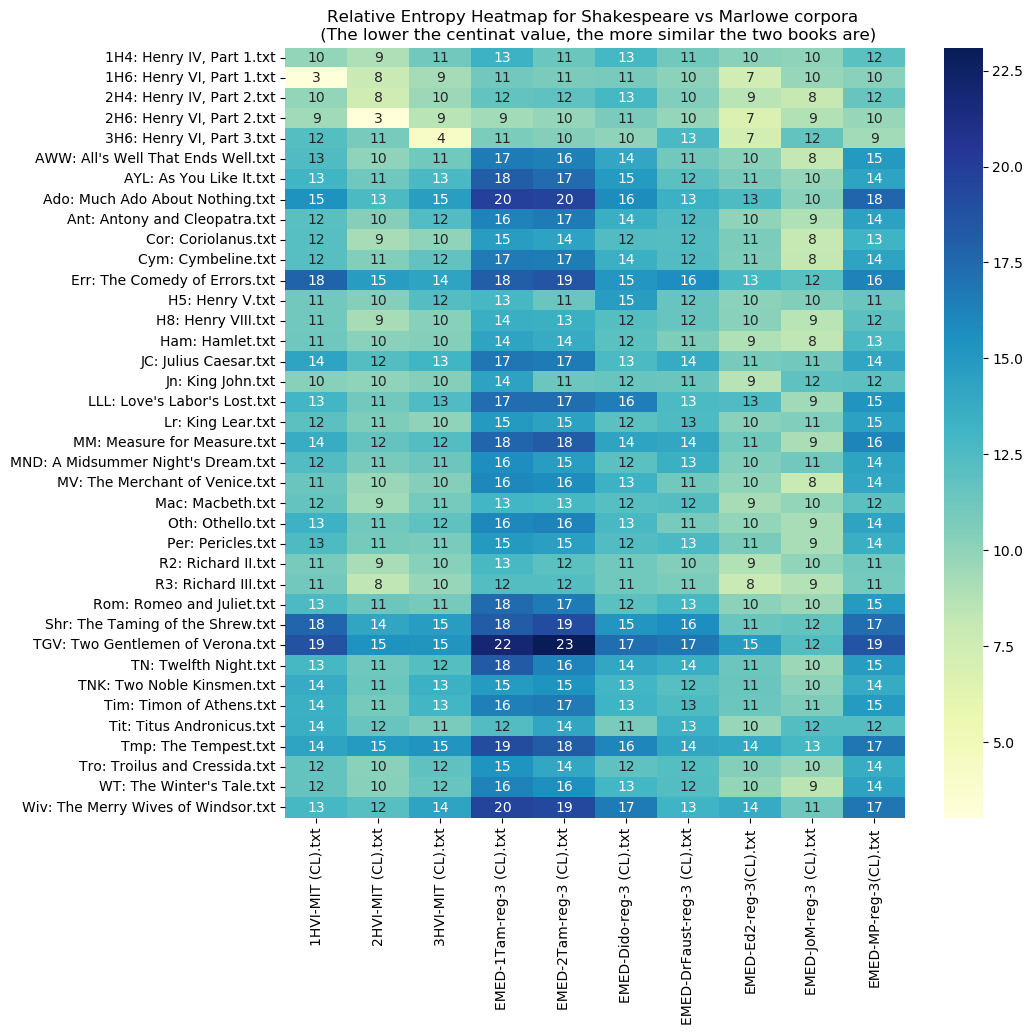

In [38]:
def plot_heatmap(df):
    plt.figure(figsize=(10, 10)) # You can adjust the figure size here, the first number is the width and the second is the height
    sns.heatmap(df, cmap="YlGnBu", annot=True, fmt=".0f")  # You can disable the annot=True by setting it False if you don't want the numbers in the heatmap
    plt.title("Relative Entropy Heatmap for Shakespeare vs Marlowe corpora \n (The lower the centinat value, the more similar the two books are)")
    plt.show()

plot_heatmap(df)